<a href="https://colab.research.google.com/github/sumasree10/OIBSIP/blob/main/Project_5_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numpy pandas scikit-learn matplotlib seaborn


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv (1).zip to creditcard.csv (1).zip


In [ ]:
import pandas as pd
import io
file_name = list(uploaded.keys())[0]
if file_name.endswith('.zip'):
    import zipfile
    with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
        zip_ref.extractall()
    import os
    for f in os.listdir():
        if f.endswith('.csv'):
            file_name = f
data = pd.read_csv(file_name)
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
X = data.drop('Class', axis=1)
y = data['Class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return {'auc': auc, 'ap': ap, 'report': report, 'cm': cm}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
res_rf = evaluate_model(rf, X_train_res, y_train_res, X_test, y_test)
print('RF AUC', res_rf['auc'], 'AP', res_rf['ap'])
print(res_rf['report'])
print(res_rf['cm'])


RF AUC 0.9685285622408784 AP 0.8760154405738982
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56847    17]
 [   17    81]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
res_gb = evaluate_model(gb, X_train, y_train, X_test, y_test)
print('GB AUC', res_gb['auc'], 'AP', res_gb['ap'])
print(res_gb['report'])
print(res_gb['cm'])


GB AUC 0.9678969083412768 AP 0.6700483191717497
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.86      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56839    25]
 [   14    84]]


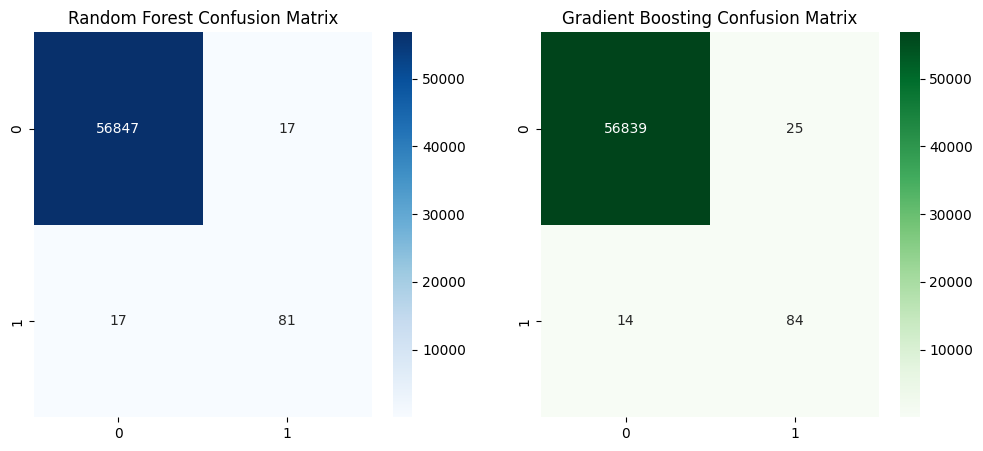

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(res_rf['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
sns.heatmap(res_gb['cm'], annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Gradient Boosting Confusion Matrix')
plt.show()


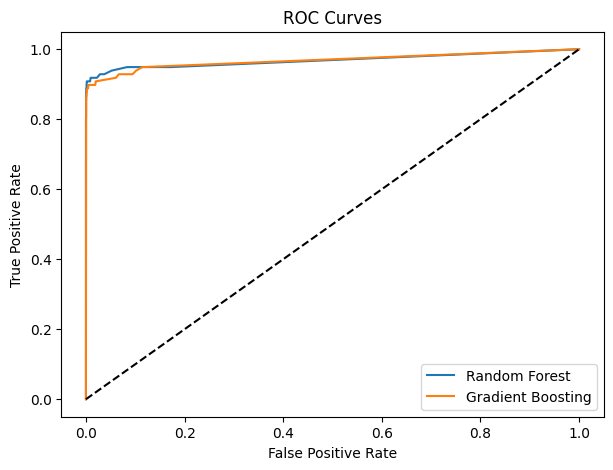

In [ ]:
from sklearn.metrics import roc_curve

y_proba_rf = rf.predict_proba(X_test)[:,1]
y_proba_gb = gb.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)

plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
